In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix

In [2]:
def calc_acc(annoy_indices, knn_indices, k):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res2 = []
    for a in aa:
        acc2 = 0
        for i in range(len(a)):
            acc2 += a[i]
        if not len(a):
            res2.append(0)
        else:
            res2.append(acc2/len(a))
    return np.array(res2).mean()
def calc_nDCG(annoy_indices, knn_indices, k, discount = 3):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res = []
    for a in aa:
        acc = 0
        for i in range(len(a)):
            acc += a[i]/math.log(i+7, 7)
        if not len(a):
            res.append(0)
        else:
            res.append(acc/len(a))
    return np.array(res).mean()


## loading data

In [3]:
chetor_content = pd.read_csv('./pages_chetor.csv')
chetor_content.head(20)

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
0,2177439,2020-08-09 04:51:12.676435+04:30,"{0.52510529756546,-0.51316374540329,-0.3844181...",وردپرس › خطا,chetor.com/,1,f,f,f,f,148948,336,"{-0.90155690908432,-1.60752034187317,0.1689879...",1015133.0,{}
1,973115,2020-08-09 03:50:47.939727+04:30,"{-0.111537165939808,0.314831465482712,-0.60968...",تبلیغات در وب سایت چطور | چطور,chetor.com/%D8%AA%D8%A8%D9%84%DB%8C%D8%BA%D8%A...,1,t,f,f,t,27016495,336,"{-1.89593696594238,0.659652948379517,-0.852037...",NaN,{}
2,975692,2020-08-09 03:50:49.22613+04:30,"{0.628654301166534,-0.548453748226166,-0.25651...",همکاری با ما | چطور,chetor.com/%D9%87%D9%85%DA%A9%D8%A7%D8%B1%DB%8...,1,t,f,f,t,27004594,336,"{-2.04737234115601,2.28955912590027,-2.1406197...",333341.0,{}
3,2144818,2020-08-09 04:49:41.361098+04:30,"{0.350972026586533,-0.0532753616571426,-0.2103...",چرا باید توسعه فردی را جدی بگیرید؟- چطور,chetor.com/100-%DA%86%D8%B1%D8%A7-%D8%A8%D8%A7...,1,t,f,f,f,5274753,336,"{2.27225732803345,0.7027268409729,0.4857064485...",599277.0,{}
4,2157999,2020-08-09 04:50:09.423651+04:30,"{1.79109728336334,-1.05194425582886,-1.3205879...",دلایل سرد بودن دستان چیست؟ | چطور,chetor.com/100026-%D8%B3%D8%B1%D8%AF-%D8%A8%D9...,1,t,f,f,f,2416997,336,"{2.48906230926514,-1.19906878471375,-1.4995402...",1485027.0,{}
5,4465070,2020-10-06 11:10:31.622853+03:30,"{0.683604598045349,-0.237597540020943,0.257590...",افسوس های من | چطور,chetor.com/100041-%D8%A7%D9%81%D8%B3%D9%88%D8%...,1,t,f,t,t,38243000,336,NaN,1012527.0,{}
6,2142257,2020-08-09 04:49:40.250501+04:30,"{0.63472980260849,0.145868331193924,0.12041924...",خانه پدربزرگ | چطور,chetor.com/100044-%D8%AE%D8%A7%D9%86%D9%87-%D9...,1,t,f,f,f,6160851,336,"{1.89609825611115,1.75975489616394,2.689968109...",1012527.0,{}
7,2123739,2020-08-09 04:48:50.486508+04:30,"{0.63071072101593,-0.431413412094116,-0.302038...",درددل های زیادی در دل اطرافیانم مانده | چطور,chetor.com/100049-%D8%AF%D8%B1%D8%AF%D8%AF%D9%...,1,t,f,f,f,11269955,336,"{1.16336917877197,0.0402661710977554,0.3318648...",NaN,{}
8,2161889,2020-08-09 04:50:45.622368+04:30,"{2.3618381023407,-0.220653653144836,-1.4399104...",درمان سردرد و تسکین فوری آن با ۱۴ روش موثر و ی...,chetor.com/100085-%D8%AF%D8%B1%D9%85%D8%A7%D9%...,1,t,f,f,f,2262178,336,"{2.5592200756073,0.69496887922287,-2.160656929...",1013280.0,{}
9,2161493,2020-08-09 04:50:45.464757+04:30,"{1.23862218856812,-0.99531877040863,-0.5665395...",آیا موز چاق کننده است؟ | چطور,chetor.com/100187-%D8%A2%DB%8C%D8%A7-%D9%85%D9...,1,t,f,f,f,2273389,336,"{1.81400036811829,-1.17559599876404,-1.4106029...",1013170.0,{}


In [4]:
print(chetor_content.shape)

(9640, 15)


In [5]:
chetor_content = chetor_content[chetor_content.included == 't']
chetor_content.shape

(8723, 15)

In [6]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load('./chetor.com/view_matrix/item_indexer.indexer')
        self.user_indexer = AppendIndexer.load('./chetor.com/view_matrix/user_indexer.indexer')
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

## colaborative filtering train

In [7]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 2, 
                      item_min_view = 2)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./chetor.com/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./chetor.com/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./chetor.com/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors, alsTime

In [13]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors, alsTime = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 20)

View matrix loaded in 11.137641906738281 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 25.40851068496704 seconds.

ALS model is fitted in 20.37936520576477 seconds.
Saving Data ...


In [9]:
sparce_matrix40, implicit_matrix40, item_vectors40, user_vectors40, alsTime40 = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 40)

View matrix loaded in 7.548845529556274 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 17.722225427627563 seconds.

ALS model is fitted in 127.33969187736511 seconds.
Saving Data ...


In [10]:
# implicit_matrix = implicit_matrix.toarray()
# sparce_matrix = sparce_matrix.toarray()

In [11]:
sparce_matrix.shape

(2097150, 8190)

In [12]:
implicit_matrix.shape

(233197, 6877)

## KNN Models

In [8]:
def sk_KNN(item_vectors, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    
    return knn_distances_brute, knn_indices_brute

In [9]:
def sk_KNN_c(item_vectors, mapper, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    a = [[mapper[j] for j in i]for i in knn_indices_brute]
    
    return knn_distances_brute, a

In [13]:
def get_annoy_results(pages_vector, number_of_trees = 20, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
#     print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [11]:
def get_annoy_results_c(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(300, 'angular')
    
    for index, vector in pages_vector.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
#     print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

## Runing KNN collaborative filtering

In [17]:
annoy_indices_CF, annoy_distances, duration = get_annoy_results(item_vectors)

annoy time: 6.241101503372192


In [18]:
knn_distances_brute, knn_indices_brute = sk_KNN(item_vectors)

ball_tree time: 1.4761583805084229


In [19]:
print(annoy_indices_CF[5744])
print(knn_indices_brute[5744])

[5744, 4041, 4886, 5025, 1284, 1057, 5772, 1427, 5510, 2189, 6161, 5674, 4774, 2647, 6048, 4556, 5548, 3276, 2554, 3043, 5484, 2543, 3530, 3042, 3226, 2606, 2642, 2492, 6677, 5107]
[5744 5772 2798 4758 6639 5346 5360 5337 3792 2642 3584 4041 2081 5836
 4780 6527 5008 4867 4712 5910 4726 5034 4472 5630 4794 4846 6168 5759
  594 4941]


In [16]:
item_indexer1 = \
AppendIndexer.load('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')

In [21]:
chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(4539))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(3357))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(1364))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(800))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
5059,2156702,2020-08-09 04:50:08.834911+04:30,"{0.509120881557465,-1.08496379852295,-0.249915...",ارزیابی ۳۶۰ درجه چیست و چه مزایا و معایبی دارد...,chetor.com/23451-%D8%A7%D8%B1%D8%B2%DB%8C%D8%A...,1,t,f,f,f,2490645,336,"{1.02428507804871,-0.387193650007248,0.2601181...",139097.0,{}


## train content based

In [17]:
items = []
nulls = []
for i in item_indexer1.get_items():
    temp = {}
    try:
        item_index = item_indexer1.get(i)
        c_vec = np.array(chetor_content[chetor_content['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        items.append(temp)
    except:
        nulls.append(item_index)

In [18]:
item_content_map = {}
for i in items:
    item_content_map[i['index']] = i['content_vec']
content_vec = []
items_itex = []
for i, j in item_content_map.items():
    content_vec.append(j)
    items_itex.append(i)
# items_itex.index(1600)

In [24]:
annoy_indices_CB, annoy_distances_CB, duration_CB = get_annoy_results_c(item_content_map)

annoy time: 4.994776010513306


In [25]:
knn_distances_brute_CB, knn_indices_brute_CB = sk_KNN_c(content_vec, items_itex)

ball_tree time: 24.46805715560913


In [26]:
print(annoy_indices_CB[6300])
print(knn_indices_brute_CB[6300])

[6758, 3219, 3027, 2311, 4787, 4424, 1790, 1977, 6037, 5307, 5496, 3386, 2232, 1234, 6199, 3688, 2008, 5286, 1027, 3956, 4937, 2930, 6081, 3259, 6115, 4099, 618, 40, 5497, 5894]
[6758, 3027, 1790, 1977, 4424, 6037, 2311, 6081, 1027, 3956, 6199, 1390, 4787, 40, 5286, 4491, 5307, 1234, 2647, 5496, 3219, 5113, 3123, 5790, 1437, 5370, 4720, 2523, 4345, 5020]


In [27]:
chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(3123))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
2365,2138598,2020-08-09 04:49:18.183412+04:30,"{0.675059735774994,-0.17669515311718,-0.160999...",تکنیک اتاق رومی؛ چطور هر فهرستی را به‌راحتی به...,chetor.com/158064-%D8%AA%DA%A9%D9%86%DB%8C%DA%...,1,t,f,f,f,7857591,336,"{0.926600635051727,0.212246716022491,0.1147326...",1012473.0,{}


## Annoy accuracy

collab

In [53]:
Tknn_distances_brute, Tknn_indices_brute = sk_KNN(item_vectors, number_of_neighbours = 30)

ball_tree time: 1.118959665298462


In [84]:
allt2 = []
allndcgs2 = []
for i in tqdm(range(30)):
    tt = []
    accs = []
    ndcgs = []
    trees = [3, 5,6,7,8,9, 10, 12,13,14, 15, 20, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200, 250,  300]
    for i in trees:
        Tannoy_indices_CF, Tannoy_distances, Tduration = get_annoy_results(item_vectors, number_of_trees = i, number_of_neighbours = 10)
        tt.append(6877/Tduration)
        accs.append(calc_acc(Tannoy_indices_CF, Tknn_indices_brute, 11))
        ndcgs.append(calc_nDCG(Tannoy_indices_CF, Tknn_indices_brute, 11))
    allt2.append(tt)
    allndcgs2.append(ndcgs)
allt2 = np.array(allt2)
allndcgs2 = np.array(allndcgs2)

100%|██████████| 30/30 [22:57<00:00, 45.92s/it]


In [85]:
allt3 = np.mean(allt2, axis = 0)
allndcgs3 = np.mean(allndcgs2, axis = 0)

In [86]:
allndcgs3

array([0.17989626, 0.1971923 , 0.20107075, 0.20364993, 0.20523201,
       0.20611203, 0.20745645, 0.20874514, 0.20918197, 0.20956556,
       0.20989382, 0.21156381, 0.21305667, 0.2130742 , 0.21290128,
       0.21290505, 0.21296602, 0.2129954 , 0.2129602 , 0.21287672,
       0.21288217, 0.2128651 , 0.21276684, 0.21281115, 0.21288474,
       0.21290095])

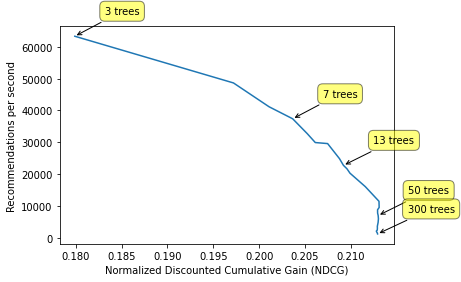

In [87]:
plt.plot(allndcgs3, allt3)
plt.ylabel("Recommendations per second")
plt.xlabel("Normalized Discounted Cumulative Gain (NDCG)")
for i in [0,3,8,16, 25]:
    plt.annotate(
            str(trees[i]) + " trees",
            xy=(allndcgs3[i], allt3[i]), xytext=(30, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

content

In [22]:
Aknn_distances_brute_CB, Aknn_indices_brute_CB = sk_KNN_c(content_vec, items_itex, number_of_neighbours = 15)

ball_tree time: 21.21881628036499


In [23]:
8723/22.65732431411743

384.99691662906696

In [24]:
allt = []
allndcgs = []
for i in tqdm(range(30)):
    tt = []
    accs = []
    ndcgs = []
    trees = [3, 5,6,7,8,9, 10,11,13, 15, 20, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200, 250,  300]
    for i in trees:
        Tannoy_indices_CB, Tannoy_distances_CB, Tduration_CB = get_annoy_results_c(item_content_map, number_of_trees = i, number_of_neighbours = 10)
        tt.append(8723/Tduration_CB)
        accs.append(calc_acc(Tannoy_indices_CB, Aknn_indices_brute_CB, 10))
        ndcgs.append(calc_nDCG(Tannoy_indices_CB, Aknn_indices_brute_CB, 13))
    allt.append(tt)
    allndcgs.append(ndcgs)
allt = np.array(allt)
allndcgs = np.array(allndcgs)


100%|██████████| 30/30 [20:36<00:00, 41.23s/it]


In [25]:
allt1 = np.mean(allt, axis = 0)
allndcgs1 = np.mean(allndcgs, axis = 0)

In [45]:
allt1

array([13062.22513926, 13144.43132901, 13090.        , 13000.        ,
       13021.48350311, 12856.22609051, 12643.43700066, 12338.53301243,
       11857.15919264, 11781.57680775, 10787.29231   ,  8574.00410787,
        8198.34145654,  7814.45774902,  7389.62952005,  6830.67919979,
        6322.09581393,  5437.72738056,  4547.77427534,  3829.98377821,
        3353.02676277,  2966.75804392,  2685.62571284,  2250.57507919,
        1855.94169423])

In [46]:
allndcgs1

array([0.47478308, 0.49533032, 0.50411199, 0.50976604, 0.51436786,
       0.51690037, 0.5211133 , 0.52603394, 0.53218338, 0.53620954,
       0.54939816, 0.57338015, 0.57612011, 0.57806205, 0.58064416,
       0.58363287, 0.587284  , 0.59003156, 0.59316942, 0.59452721,
       0.59593304, 0.59649455, 0.5974536 , 0.59840549, 0.59885689])

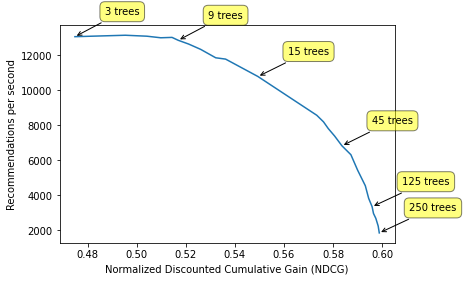

In [81]:
from brokenaxes import brokenaxes
plt.plot(allndcgs1, allt1)
plt.ylabel("Recommendations per second")
plt.xlabel("Normalized Discounted Cumulative Gain (NDCG)")
for i in [0,5,10,15,20, 24]:
    plt.annotate(
            str(trees[i]) + " trees",
            xy=(allndcgs1[i], allt1[i]), xytext=(30, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

## time - #features

In [12]:
alst = []
annoyt = []
knnt = []
accs = []
ndcgs = []
features = [5, 10, 20, 30, 40, 60, 80, 100, 120]
# matrix = ViewMatrix.load_matrix('./chetor.com/view_matrix/lil_matrix.npz')
# print('hi')
# sparce_matrix = matrix.to_csr()
# matrix.make_dense(user_min_view = 2, 
#                   item_min_view = 2)
# implicit_matrix = matrix.to_csr()
# print('hi')

In [42]:
for i in features:
    als_model = ALS.Als(num_factors = i,
                    iterations = 15,
                    num_threads = 15,
                    alpha = 15)
    now = time.time()
    als_model.fit(implicit_matrix)
    alst.append(time.time() - now)
    print(alst[-1])
    
    now = time.time()
    annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(als_model.item_vectors, number_of_neighbours = 10)
    annoyt.append(time.time() - now)
    
    now = time.time()
    knn_distances_brutei, knn_indices_brutei = sk_KNN(als_model.item_vectors, number_of_neighbours = 10)
    knnt.append(time.time() - now)
    
    accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
    ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))
    
    print(accs[-1], ndcgs[-1])
    

In [14]:
sparce_matrix5, implicit_matrix5, item_vectors5, user_vectors5, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 5)
alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors5, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors5, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.3962953090667725 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.183908224105835 seconds.

ALS model is fitted in 5.996797323226929 seconds.
Saving Data ...
ball_tree time: 0.293595552444458


In [15]:
sparce_matrix10, implicit_matrix10, item_vectors10, user_vectors10, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 10)
alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors10, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors10, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.193766832351685 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.730817556381226 seconds.

ALS model is fitted in 7.9667723178863525 seconds.
Saving Data ...
ball_tree time: 0.5714569091796875


In [16]:
sparce_matrix15, implicit_matrix15, item_vectors15, user_vectors15, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 15)
alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors15, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors15, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 6.017201662063599 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.214616775512695 seconds.

ALS model is fitted in 9.851269960403442 seconds.
Saving Data ...
ball_tree time: 0.7856690883636475


In [17]:
sparce_matrix20, implicit_matrix20, item_vectors20, user_vectors20, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 20)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors20, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors20, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.967483758926392 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 14.976257085800171 seconds.

ALS model is fitted in 10.88638186454773 seconds.
Saving Data ...
ball_tree time: 1.0011837482452393


In [18]:
sparce_matrix25, implicit_matrix25, item_vectors25, user_vectors25, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 25)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors25, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors25, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.951243162155151 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.388915777206421 seconds.

ALS model is fitted in 14.326810359954834 seconds.
Saving Data ...
ball_tree time: 1.3874289989471436


In [19]:
sparce_matrix30, implicit_matrix30, item_vectors30, user_vectors30, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 30)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors30, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors30, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.958970308303833 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.35277533531189 seconds.

ALS model is fitted in 19.01391100883484 seconds.
Saving Data ...
ball_tree time: 1.4627258777618408


In [20]:
sparce_matrix35, implicit_matrix35, item_vectors35, user_vectors35, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 35)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors35, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors35, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.9334876537323 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.15571904182434 seconds.

ALS model is fitted in 87.13678884506226 seconds.
Saving Data ...
ball_tree time: 1.7800700664520264


In [21]:
sparce_matrix40, implicit_matrix40, item_vectors40, user_vectors40, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 40)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors40, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors40, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.9728782176971436 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.430633068084717 seconds.

ALS model is fitted in 89.21655130386353 seconds.
Saving Data ...
ball_tree time: 1.8687613010406494


In [22]:
sparce_matrix50, implicit_matrix50, item_vectors50, user_vectors50, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 50)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors50, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors50, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.94551944732666 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.378552675247192 seconds.

ALS model is fitted in 111.91834902763367 seconds.
Saving Data ...
ball_tree time: 2.3547425270080566


In [23]:
sparce_matrix60, implicit_matrix60, item_vectors60, user_vectors60, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 60)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors60, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors60, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.947584390640259 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.027578353881836 seconds.

ALS model is fitted in 145.3013882637024 seconds.
Saving Data ...
ball_tree time: 2.8356781005859375


In [24]:
sparce_matrix80, implicit_matrix80, item_vectors80, user_vectors80, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 80)


alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors80, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors80, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.989086866378784 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 14.854389190673828 seconds.

ALS model is fitted in 316.5426483154297 seconds.
Saving Data ...
ball_tree time: 4.83540153503418


In [25]:
sparce_matrix100, implicit_matrix100, item_vectors100, user_vectors100, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 100)


alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors100, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors100, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.91612982749939 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.28990364074707 seconds.

ALS model is fitted in 462.81884026527405 seconds.
Saving Data ...
ball_tree time: 6.870043754577637


In [26]:
sparce_matrix120, implicit_matrix120, item_vectors120, user_vectors120, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 120)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors120, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors120, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.918943166732788 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.120127201080322 seconds.

ALS model is fitted in 605.1361429691315 seconds.
Saving Data ...
ball_tree time: 8.484991788864136


In [27]:
sparce_matrix140, implicit_matrix140, item_vectors140, user_vectors140, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 140)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors140, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors140, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.9740118980407715 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 14.921702861785889 seconds.

ALS model is fitted in 925.0773742198944 seconds.
Saving Data ...
ball_tree time: 10.247362852096558


In [28]:
sparce_matrix160, implicit_matrix160, item_vectors160, user_vectors160, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 160)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors160, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors160, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.900796175003052 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.255890369415283 seconds.

ALS model is fitted in 1268.7510783672333 seconds.
Saving Data ...
ball_tree time: 11.631413221359253


In [29]:
sparce_matrix180, implicit_matrix180, item_vectors180, user_vectors180, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 180)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors180, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors180, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.911494493484497 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.121493816375732 seconds.

ALS model is fitted in 1632.2262499332428 seconds.
Saving Data ...
ball_tree time: 12.792319059371948


In [30]:
sparce_matrix200, implicit_matrix200, item_vectors200, user_vectors200, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 200)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors200, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors200, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.999379634857178 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 14.933590650558472 seconds.

ALS model is fitted in 2792.90002989769 seconds.
Saving Data ...
ball_tree time: 14.305928230285645


In [31]:
sparce_matrix220, implicit_matrix220, item_vectors220, user_vectors220, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 220)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors220, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors220, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.90336799621582 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.308510065078735 seconds.

ALS model is fitted in 3443.1665573120117 seconds.
Saving Data ...
ball_tree time: 15.572222232818604


In [32]:
sparce_matrix240, implicit_matrix240, item_vectors240, user_vectors240, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 240)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors240, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors240, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.900949716567993 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.164297342300415 seconds.

ALS model is fitted in 3938.202852010727 seconds.
Saving Data ...
ball_tree time: 16.91199517250061


In [33]:
sparce_matrix260, implicit_matrix260, item_vectors260, user_vectors260, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 260)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors260, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors260, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.862349987030029 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 14.86496877670288 seconds.

ALS model is fitted in 5775.3356420993805 seconds.
Saving Data ...
ball_tree time: 18.200908660888672


In [34]:
sparce_matrix280, implicit_matrix280, item_vectors280, user_vectors280, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 280)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors280, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors280, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 5.851789951324463 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 15.314847469329834 seconds.

ALS model is fitted in 6518.397986412048 seconds.
Saving Data ...
ball_tree time: 19.272705554962158


In [35]:
print(alst)
print(annoyt)
print(knnt)
print(accs)
print(ndcgs)

[5.996794939041138, 7.966770648956299, 9.85126805305481, 10.886379718780518, 14.326808214187622, 19.013908624649048, 87.1367871761322, 89.216548204422, 111.91834664344788, 145.30138635635376, 316.54264545440674, 462.8188376426697, 605.1361405849457, 925.0773725509644, 1268.7510752677917, 1632.2262470722198, 2792.900027990341, 3443.16655421257, 3938.202849149704, 5775.33563876152, 6518.397983074188]
[0.43730664253234863, 0.39748311042785645, 0.42919206619262695, 0.39527463912963867, 0.36992383003234863, 0.38253331184387207, 0.3278474807739258, 0.31162357330322266, 0.3213789463043213, 0.34222912788391113, 0.3293783664703369, 0.36707448959350586, 0.3823685646057129, 0.4134972095489502, 0.4327254295349121, 0.47090649604797363, 0.5074958801269531, 0.5322380065917969, 0.5534987449645996, 0.5882666110992432, 0.5951831340789795]
[0.29407739639282227, 0.5717000961303711, 0.7858848571777344, 1.0015788078308105, 1.3876926898956299, 1.4629156589508057, 1.780263900756836, 1.8689532279968262, 2.3549

In [ ]:
alst = [7.289317607879639, 9.750426769256592, 14.307723760604858, 25.630435466766357, 141.31052207946777, 245.95699858665466, 531.0659351348877, 1182.7597563266754, 889.0909335613251, 2246.1444799900055]
annoyt = [4.7668375968933105, 3.9713222980499268, 3.6236677169799805, 3.494922161102295, 2.913334369659424, 3.168506622314453, 2.6421518325805664, 2.6659493446350098, 3.134293794631958, 3.1395812034606934]
knnt = [0.3691706657409668, 0.6302402019500732, 1.2295241355895996, 1.8892674446105957, 2.3320982456207275, 5.420377492904663, 6.786769866943359, 7.923229217529297, 17.07801127433777, 14.070316791534424]
accs = [0.12670253502011536, 0.19889163556460343, 0.24400174494692453, 0.2736335288320165, 0.2908244874218409, 0.31389656342397365, 0.3343996897872134, 0.34385148562842327, 0.3570032152262776, 0.36887854846266943]
ndcgs = [0.10664456717637862, 0.16809047723368792, 0.206169213939166, 0.23102143279005524, 0.24551619649065584, 0.26460049649718315, 0.2816905352556345, 0.2899726504051018, 0.3008974967463259, 0.3109966588301528]

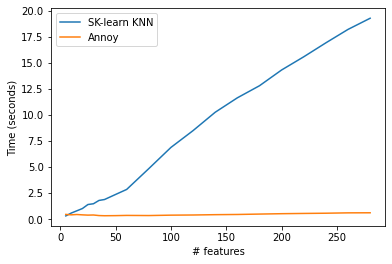

In [42]:
features = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
plt.plot(features, knnt, label = 'SK-learn KNN')
plt.plot(features, annoyt, label = 'Annoy')
plt.xlabel('# features')
plt.ylabel('Time (seconds)')
plt.legend(loc="upper left")

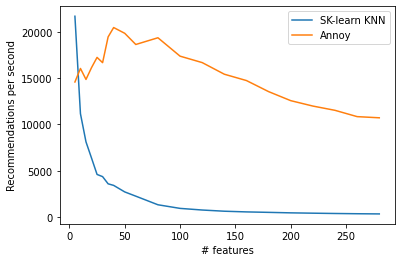

In [43]:
features = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
plt.plot(features, 6378/np.array(knnt), label = 'SK-learn KNN')
plt.plot(features, 6378/np.array(annoyt), label = 'Annoy')
plt.xlabel('# features')
plt.ylabel('Recommendations per second')
plt.legend(loc="upper right")

## acc-time-#features

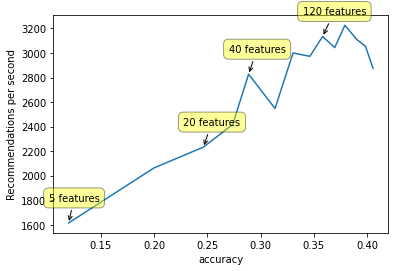

In [84]:
att = 6378/np.array(annoyt)
plt.plot(accs, att)
plt.ylabel("Recommendations per second")
plt.xlabel("accuracy")
for i in [0,2,4,8]:
    plt.annotate(
            str(features[i]) + " features",
            xy=(accs[i], att[i]), xytext=(-20, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

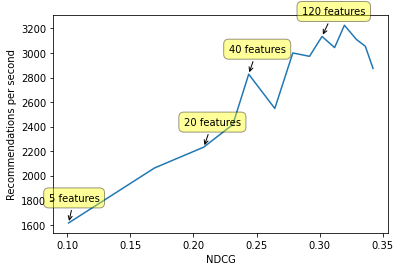

In [85]:
att = 6378/np.array(annoyt)
plt.plot(ndcgs, att)
plt.ylabel("Recommendations per second")
plt.xlabel("NDCG")
for i in [0,2,4,8]:
    plt.annotate(
            str(features[i]) + " features",
            xy=(ndcgs[i], att[i]), xytext=(-20, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

## Precision Recall @k and MAE

In [28]:
now = time.time()
aproximated_matrix = np.matmul(user_vectors, np.transpose(item_vectors))
time.time() - now

19.879060983657837

In [30]:
start = time.time()
# implicit_matrix = implicit_matrix.toarray()
absolute_error = abs(aproximated_matrix - implicit_matrix)
time.time() - start

232.96968388557434

In [31]:
start = time.time()
MAE = absolute_error.mean()
time.time() - start

71.03863096237183

In [32]:
MAE

0.009043916284864414

In [27]:
idk = []
for i in tqdm(range(len(implicit_matrix))):
    temp = []
    for j in range(len(implicit_matrix[i])):
        if implicit_matrix[i][j] > 0:
            temp.append((implicit_matrix[i][j], j))
    idk.append(temp)

100%|██████████| 233197/233197 [18:19<00:00, 212.01it/s]


In [41]:
idk2 = []
for i in tqdm(range(len(aproximated_matrix))):
    temp = []
    for j in range(len(aproximated_matrix[i])):
        if aproximated_matrix[i][j] > 0.3:
            temp.append((aproximated_matrix[i][j], j))
    idk2.append(temp)

100%|██████████| 233197/233197 [15:20<00:00, 253.30it/s]


In [80]:
for i in tqdm(range(len(idk2))):
    idk2[i] = sorted(idk2[i], key=lambda x: x[0], reverse=True)

100%|██████████| 233197/233197 [00:00<00:00, 263142.36it/s]


In [86]:
def Precision_recall_at_k(idk2, idk, k):
    users_visited_indeces = \
    [[i[1] for i in idk[j]] for j in range(len(idk))]
#     print(users_visited_indeces[0:10])
    recommended_relevant = []
    relevants = []
    for i in range(len(idk2)):
        temp = 0
        if len(idk2[i]) >= k and len(users_visited_indeces[i]) >= k:
            for j in range(len(idk2[i][0:k+1])):
                if idk2[i][j][1] in users_visited_indeces[i]:
                    temp += 1
            recommended_relevant.append(temp)
            relevants.append(len(users_visited_indeces[i]))
    p = (np.array(recommended_relevant) / k).mean()
    r = []
    for i in zip(recommended_relevant, relevants):
        r.append(i[0]/i[1])
    r = np.array(r).mean()
    return p, r

In [87]:
for k in range(1, 20):
    print('k =', k, Precision_recall_at_k(idk2, idk, k))

k = 1 (0.7186354499231405, 0.3132991983320419)
k = 2 (0.45802332358454406, 0.39563191122090663)
k = 3 (0.3964406552864489, 0.33340775120759264)
k = 4 (0.3518457896857373, 0.28333117710725014)
k = 5 (0.3264939622252039, 0.2523960932844422)
k = 6 (0.31026053776903356, 0.231139391231143)
k = 7 (0.30018033558099416, 0.2186396367495723)
k = 8 (0.29234575087310827, 0.20980850487899763)
k = 9 (0.2872784150156413, 0.204103039836464)
k = 10 (0.2821524064171123, 0.1993732143623082)
k = 11 (0.27719190208605954, 0.1940893510669637)
k = 12 (0.2746406570841889, 0.19230763612031124)
k = 13 (0.2700897117770567, 0.18766172434375045)
k = 14 (0.2647549530761209, 0.1844010920044037)
k = 15 (0.25830429732868754, 0.17646792331281605)
k = 16 (0.2542162698412698, 0.17401698465680013)
k = 17 (0.24929360390444388, 0.17363907796836417)
k = 18 (0.244718792866941, 0.17004162464521388)
k = 19 (0.24428718855963436, 0.1696894556403601)


## popularity bias wrt alg

In [178]:
def CFTrain2(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 1, 
                      item_min_view = 1)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./chetor.com/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./chetor.com/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./chetor.com/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors, alsTime

In [132]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors, alsTime = \
CFTrain2('./chetor.com/view_matrix/lil_matrix.npz', factors = 20, _alpha = 1)

View matrix loaded in 8.806686878204346 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 26.60288381576538 seconds.

ALS model is fitted in 17.589404106140137 seconds.
Saving Data ...


In [166]:
implicit_matrix = implicit_matrix.toarray()

In [167]:
popularity_count = {}
for i, j in tqdm(enumerate(implicit_matrix.T)):
    popularity_count[i] = np.greater(j, 0).sum()

6877it [00:57, 118.72it/s]


In [168]:
site_trend = {k: v for k, v in sorted(popularity_count.items(), key=lambda item: item[1], reverse = True)}

In [169]:
len(site_trend)

6877

In [170]:
pop = []
item = []
for i, j in site_trend.items():
    pop.append(j)
    item.append(i)

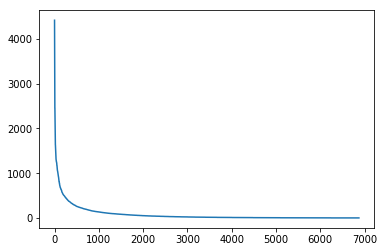

In [171]:
plt.plot(pop[3:])

In [172]:
ind, dis, d = get_annoy_results(item_vectors, number_of_neighbours = 30)
ind2 = []
for i in ind:
    ind2.append(i[1:])

annoy time: 5.80443811416626


In [173]:
ind2 = np.array(list((np.array(ind2)).flatten()))

In [157]:
knn_indices_brutei_st = np.array(list((np.array(knn_indices_brutei_st)).flatten()))

In [174]:
res = []
for i in item:
    res.append(np.equal(ind2, i).sum())

In [159]:
def a(s):
    r = []
    for i in range(len(s)-500):
        r.append(np.array(s[i:i+500]).mean())
    return r

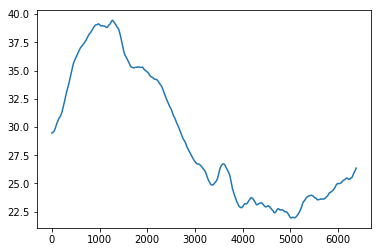

In [177]:
res = a(res)
plt.plot(res)